# **<font color="#A41034">Text Classification using BERT</font>**

<hr style="height:2pt">

## **<font color="#A41034">Setup Notebook</font>**

**Copy & setup Colab with GPU**

1) Select "File" menu and pick "Save a copy in Drive"  
2) This notebooks is already setup to use GPU but if you want to change it. Go to "Runtime" menu and select "Change runtime type". Then in the popup in "Hardware accelerator" select "GPU" and then click "Save"   
3) If you want high RAM there is an option for that

**Installs**

We will install Huggingface’s transformers library. This library let us import a wide range of transformer-based pre-trained modelssuch as GPT2 & BERT. Wer will use this for downloading the BERT model

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.4 MB/s 
     |████████████████████████████████| 895 kB 52.9 MB/s 
     |████████████████████████████████| 6.6 MB 37.2 MB/s 
     |████████████████████████████████| 596 kB 48.7 MB/s 
     |████████████████████████████████| 77 kB 5.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


**Imports**

In [ ]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import string
import re
import numpy as np
import pandas as pd
from glob import glob
import collections
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow.python.keras import backend as K

# sklearn
from sklearn.model_selection import train_test_split

# Transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a A100, V100, P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow.

In [ ]:
!nvidia-smi

Wed Apr 13 17:42:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    37W / 300W |    473MiB / 16160MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **<font color="#A41034">Text Classification</font>**

### **Overview**

In this tutorial, we're going to be working with news articles from CNN. We will explore the dataset, prepare the data for modeling, and pretrained BERT.

**The Task:** Classify news articles into three categories, namely politics, health, and entertainment.

### **Dataset**

The dataset consists of news articles pulled from CNN in the politics, health, and entertainment categories. There are about 300 articles in each category.

#### **Download**

Download the datasets to colab.

In [ ]:
start_time = time.time()
# Dowload the news dataset
file_path = tf.keras.utils.get_file(
    fname="news300.zip",
    origin="https://github.com/dlops-io/datasets/releases/download/v1.0/news300.zip",
    extract=True)
data_dir = file_path.replace("news300.zip","news300")
print("data_dir:",data_dir)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

2121728/2109041 [==============================] - 0s 0us/step
data_dir: /root/.keras/datasets/news300
Download execution time (mins) 0.018874963124593098


#### **Load Data**

* Read-in data as lists.
* Each element in data_x is the content of a sample, namely an news article.
* Each element in data_y is the label of that article.

In [ ]:
label_names = os.listdir(data_dir)

# Number of unique labels
num_classes = len(label_names)
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

print("Number of classes:", num_classes)
print("Labels:", label_names)

# Generate a list of labels and path to text
data_x = []
data_y = []

for label in label_names:
  text_files = os.listdir(os.path.join(data_dir,label))
  data_x.extend([os.path.join(data_dir,label,f) for f in text_files])
  data_y.extend([label for f in text_files])

# Load the text content
for idx, path in enumerate(data_x):
  # Load text
  with open(path) as file:
    data_x[idx] = file.read()

# Preview
print("data_x count:",len(data_x))
print("data_y count:",len(data_y))
print("Label counts:",np.unique(data_y, return_counts=True))

Number of classes: 3
Labels: ['health', 'entertainment', 'politics']
data_x count: 920
data_y count: 920
Label counts: (array(['entertainment', 'health', 'politics'], dtype='<U13'), array([310, 310, 300]))


#### **View Text**

Let's take a look at the data.

In [ ]:
data_x[0]

'Mom loses hearing in one ear after mild Covid-19 infection  (CNN)One day in July, while Meredith Harrell was walking from her backyard into the house, her right ear suddenly started to ring. She realized that, other than the ringing, she couldn\'t hear anything out of that ear. "It was like someone flipped a switch," she said.   Harrell\'s hearing loss was a mystery until about a week later, when she took a Covid-19 test. It was positive.   Even though she never felt sick, an otologist -- a doctor who specializes in hearing -- explained to Harrell that the virus was likely the culprit.   Viruses such as measles, mumps and meningitis are known to sometimes cause sudden hearing loss, and there\'s growing evidence that the novel coronavirus should be added to the list.   "We\'re hearing more and more that people have hearing loss as part of their Covid infection," said Dr. Matthew Stewart, associate professor of otolaryngology at Johns Hopkins Medicine.   There are no statistics on how c

In [ ]:
data_y[0]

'health'

In [ ]:
# Generate a random sample of index
data_samples = np.random.randint(0,high=len(data_x)-1, size=10)
for i,data_idx in enumerate(data_samples):
  print("Label:",data_y[data_idx],", Text:",data_x[data_idx])

Label: health , Text: Pfizer and BioNTech begin large-scale trial of coronavirus vaccine in the United States  (CNN)Drug giant Pfizer and its partner BioNTech have begun an advanced trial of one of their experimental coronavirus vaccines in volunteers in the United States. The first four participants were dosed Monday at the University of Rochester Medical Center, a spokesman there said. The combined Phase 2/3 trial, which looks for safety, efficacy and optimal dosing of a vaccine or drug, will include up to 30,000 participants. It was the second advanced trial of a coronavirus vaccine to get under way in the United States Monday. Earlier Monday, Moderna started a Phase 3 trial in the United States of its experimental vaccine. Pfizer's vaccine is different, but also uses an experimental approach that employs genetic material to stimulate an immune response against a key part of the coronavirus. Earlier this month, Pfizer and BioNTech released preliminary data showing that one of their 

#### **Split Data**
We split data into train and validation by randomly selecting 20% as the validation set.

In [ ]:
validation_percent = 0.20

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 736
validate_x count: 184


### **Text Classificaton pretrained BERT**

#### **Build Data Pipelines**

**Text Tokenization** ([Reference](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer))

In [ ]:
# Tokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Tokenizer Example
text = ["What you need to know about using them safely amid the pandemic",
        "A third of Medicare enrollees with coronavirus ended up in the hospital"]
outputs = tokenizer.batch_encode_plus(text,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        truncation='longest_first',
        max_length=15
      )
print("Tokenizer Output:",outputs)

Tokenizer Output: {'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[  101,  2054,  2017,  2342,  2000,  2113,  2055,  2478,  2068,
         9689, 13463,  1996,  6090,  3207,   102],
       [  101,  1037,  2353,  1997, 27615, 25612, 10285,  2007, 21887,
        23350,  3092,  2039,  1999,  1996,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


* Input ids: are the only required parameters to be passed to the model as input. They are token indices, numerical representations of tokens building the sequences that will be used as input by the model.
* Attention mask: is an optional argument used when batching sequences together. This argument indicates to the model which tokens should be attended to, and which should not.
* Token type ids: Some models’ purpose is to do sequence classification or question answering. These require two different sequences to be joined in a single “input_ids” entry, which usually is performed with the help of special tokens, such as the classifier ([CLS]) and separator ([SEP]) tokens. For example, the BERT model builds its two sequence input as such:

* Here, we will tokenize news articles. To setup for BERT, we need to add special tokens,  namely [CLS] at the beginning and [SEP] at the end of each sentence. Also, we need to pad or truncate all sentences to a single constant length.

##### **Create TF Datasets**

In [ ]:
BATCH_SIZE = 8
TRAIN_SHUFFLE_BUFFER_SIZE = len(train_x)
VALIDATION_SHUFFLE_BUFFER_SIZE = len(validate_x)

# Feature constraints
sequence_length = 256

# Tokenize train x
train_x_processed = tokenizer.batch_encode_plus(
        train_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

# Tokenize validate x
validate_x_processed = tokenizer.batch_encode_plus(
        validate_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

print(train_x_processed.keys())

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = tf.keras.utils.to_categorical(train_processed_y, num_classes=num_classes, dtype='int32')
validate_processed_y = tf.keras.utils.to_categorical(validate_processed_y, num_classes=num_classes, dtype='int32')

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices(((train_x_processed["input_ids"],
                                                  train_x_processed["token_type_ids"],
                                                  train_x_processed["attention_mask"]), train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices(((validate_x_processed["input_ids"],
                                                  validate_x_processed["token_type_ids"],
                                                  validate_x_processed["attention_mask"]), validate_processed_y))

#############
# Train data
#############
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

##################
# Validation data
##################
validation_data = validation_data.shuffle(buffer_size=VALIDATION_SHUFFLE_BUFFER_SIZE)
validation_data = validation_data.batch(BATCH_SIZE)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
train_data <PrefetchDataset element_spec=((TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), TensorSpec(shape=(None, 256), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 3), dtype=tf.int32, name=None))>
validation_data <PrefetchDataset element_spec=((TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), TensorSpec(shape=(None, 256), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 3), dtype=tf.int32, name=None))>


#### **Build the Model**

In [ ]:
def build_pretrained_bert(num_classes):
  # Set the model name as
  model_name = 'bert_pretrained'
  model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes,name=model_name)
  model.layers[0].trainable=True
  return model

#### **Train**

In [ ]:
############################
# Training Params
############################
learning_rate = 2e-5
epochs = 5

# Free up memory
K.clear_session()

# Build the model
model = build_pretrained_bert(num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# Loss
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "bert_pretrained"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
92/92 [==============================] - 39s 215ms/step - loss: 0.5728 - accuracy: 0.8071 - val_loss: 0.1773 - val_accuracy: 0.9620
Epoch 2/5
92/92 [==============================] - 17s 185ms/step - loss: 0.1578 - accuracy: 0.9565 - val_loss: 0.0834 - val_accuracy: 0.9783
Epoch 3/5
92

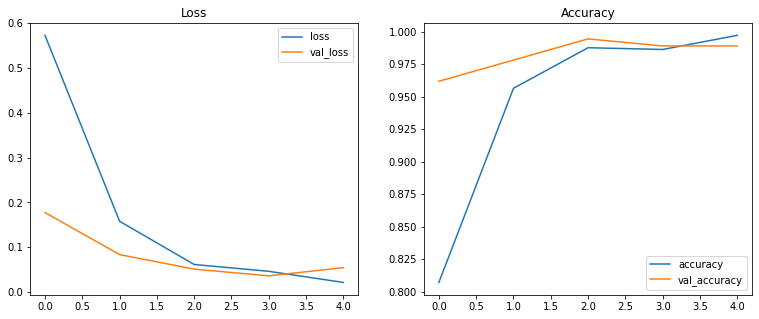

In [ ]:
# Plot training results
fig = plt.figure(figsize=(20,5))
axs = fig.add_subplot(1,3,1)
axs.set_title('Loss')
# Plot all metrics
for metric in ["loss","val_loss"]:
    axs.plot(np.arange(0, epochs), training_results.history[metric], label=metric)
axs.legend()

axs = fig.add_subplot(1,3,2)
axs.set_title('Accuracy')
# Plot all metrics
for metric in ["accuracy","val_accuracy"]:
    axs.plot(np.arange(0, epochs), training_results.history[metric], label=metric)
axs.legend()

plt.show()

#### **Make Predictions**

In [ ]:
# Generate a random sample of index
data_samples = np.random.randint(0,high=len(validate_x)-1, size=5)
for i,data_idx in enumerate(data_samples):
  print("Label:",validate_y[data_idx],", Text:",validate_x[data_idx])

  # Tokenize text
  test_x_processed = tokenizer.batch_encode_plus(
        [validate_x[data_idx]],
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

  test_data = tf.data.Dataset.from_tensor_slices(((test_x_processed["input_ids"],
                                                  test_x_processed["token_type_ids"],
                                                  test_x_processed["attention_mask"])))
  test_data = test_data.batch(1)

  # Make predictions
  predictions = model.predict(test_data)

  print("Prediction:",index2label[predictions.logits.argmax(axis=1)[0]])

Label: health , Text: CDC updates school guidelines for Covid-19 pandemic  (CNN)The US Centers for Disease Control and Prevention updated its school guidance Friday. The update adds more details to existing guidelines that will better inform administrators' decisions about opening schools and limit risk, according to CDC Director Dr. Robert Redfield.  Redfield said the updated guidance is a result of discussions the CDC has been having with districts about how to best operate during a pandemic. The updated guidelines emphasize the importance of keeping schools open if possible. Children less at risk "The many benefits of in-person schooling should be weighed against the risks posed by Covid-19," the guidelines said. The available evidence from countries that have reopened schools showed that Covid-19 "poses low risks to school-aged children - at least in areas with low community transmission." It adds that in general, children are less likely to have severe symptoms than adults. The ri